# Start Stanford CoreNLP server
`java -Xmx16g -cp C:\stanford-corenlp-latest\stanford-corenlp-4.0.0\* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9001 -timeout 600 -threads 5 -maxCharLength 100000 -quiet False -preload tokenize,ssplit,pos,lemma,ner,parse,depparse,coref`

In [1]:
import string
import re
import collections
import csv
import pandas as pd
import numpy as np
import requests
import os
import json
from hyphen import Hyphenator

import dask.dataframe as dd
import multiprocessing

import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

import seaborn as sns

%matplotlib inline

import stanfordnlp
from stanfordnlp.server import CoreNLPClient

# Uncomment if needed to fix this error:
# OMP: Error #15: Initializing libiomp5md.dll, but found libiomp5md.dll already initialized.
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
PREDICTION_PATH = './predictions'
TEST_SETS_PATH = './test_sets'
MODEL_EVALS_URL = 'https://squad-model-evals.s3-us-west-2.amazonaws.com/model_db.json'

#SET_NAMES = ['Amazon', 'Reddit', 'New-Wiki', 'NYT', 'dev-v1.1']
SET_NAMES = ['Amazon', 'Reddit', 'New-Wiki', 'NYT']

In [5]:
def fetch_eval_file(eval_file_path, model_evals_url, overwrite=False):
    if (not os.path.exists(eval_file_path)) or overwrite:
        r = requests.get(model_evals_url)
                        
        with open(eval_file_path, 'w', encoding='utf-8') as outfile:
            outfile.write(r.text)

    else:
        print('File Exists')
    
    

def write_output(output_file_path, list_to_write):
    fields = list_to_write[0].keys()
    
    with open(output_file_path, 'w', newline='', encoding='utf-8') as csv_file:
        csv_writer = csv.DictWriter(csv_file, 
                                    fieldnames=fields,
                                    delimiter=',', 
                                    quotechar='"',
                                    quoting=csv.QUOTE_MINIMAL )
        csv_writer.writeheader()
        csv_writer.writerows(list_to_write)

def parse_predictions(prediction_file_path, download=False):
    
    with open(prediction_file_path) as f:
      predictions = json.load(f)


    pred_list_test = [{ 'model_display_name': x['name'], 
      'model_name': x['metadata']['name'], 
      'description': x['metadata']['description'], 
      'uuid': x['metadata']['uuid'],
      'testbed': x['testbed'],
      'predictions': x['predictions']

     } for x in predictions]

    pred_list = []

    for r in predictions:

      display_name = r['name']
      model_name = r['metadata']['name']
      description = r['metadata']['description']
      uuid = r['metadata']['uuid']
      testbed = r['testbed']

      for k1, v1 in r['predictions'].items():
        if k1 in (SET_NAMES):
          if 'bundle' in v1.keys():
            test_set = k1
            bundle = v1['bundle']

            for k2, v2 in v1['data'].items():
              qid = k2
              predicted_answer = v2
              exact_match = v1['scores'][qid]['exact_match']
              f1 = v1['scores'][qid]['f1']

              pred_list.append( {
                'display_name': display_name,
                'model_name': model_name,
                'description': description,
                'uuid': uuid,
                'testbed': testbed,
                'test_set': test_set,
                'qid': qid,
                'predicted_answer': predicted_answer,
                'exact_match': exact_match,
                'f1': float(f1)
              })
   
    return pred_list

def load_data(input_file_path):
    with open(input_file_path, 'r', encoding='utf-8') as csv_file:
        csv_reader = csv.DictReader(csv_file)
        return [r for r in csv_reader]

def parse_answers(answer_file_path):
    test_set_answers = [a for a in os.listdir(answer_file_path) if not os.path.isdir('/'.join([answer_file_path, a]))]
    answers_list = []
    
    for f in test_set_answers:
      with open('/'.join([TEST_SETS_PATH, f])) as fh:
          test_set = f.split('.')[0]
          
          answers = json.load(fh)['data']
          for x in answers:
              title = x['title']
    
              for p in x['paragraphs']:
                  context = p['context']
    
                  for qa in p['qas']:
                      question = qa['question']
                      question_id = qa['id']
    
                      for a in qa['answers']:
                          answers_list.append(
                                  {
                                      'test_set': test_set,
                                      'question_id': question_id,
                                      'title': title,
                                      'context': context,
                                      'question_text': question,
                                      'answer_text': a['text'],
                                      'answer_start': a['answer_start']
                                  }
                              )
    return answers_list

def normalize_answer(s):
    """Lower text and remove punctuation, articles and extra whitespace."""
  
    def remove_articles(text):
        regex = re.compile(r'\b(a|an|the)\b', re.UNICODE)
        return re.sub(regex, ' ', text)
    def white_space_fix(text):
        return ' '.join(text.split())
    def remove_punc(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)
    def lower(text):
        return text.lower()
    return white_space_fix(remove_articles(remove_punc(lower(s))))

def get_tokens(s):
    if not s: return []
    return normalize_answer(s).split()

def compute_exact(question_id, predicted_answer, all_answers):
    gold_answers = [normalize_answer(x['answer_text']) for x in all_answers if x['question_id'] == question_id]
    return max((int(normalize_answer(predicted_answer) == a) for a in gold_answers))

def compute_f1(question_id, predicted_answer, all_answers):
    gold_toks = [get_tokens(x['answer_text']) for x in all_answers if x['question_id'] == question_id]
    pred_toks = get_tokens(predicted_answer)
    
    f1s = []
  
    for answer_toks in gold_toks:
        common = collections.Counter(answer_toks) & collections.Counter(pred_toks)
        num_same = sum(common.values())
      
        if len(answer_toks) == 0 or len(pred_toks) == 0:
            # If either is no-answer, then F1 is 1 if they agree, 0 otherwise
            f1s.append(float(int(answer_toks == pred_toks)))
            continue
        if num_same == 0:
            f1s.append(0.0)
            continue
            
        precision = 1.0 * num_same / len(pred_toks)
        recall = 1.0 * num_same / len(answer_toks)
        f1 = (2 * precision * recall) / (precision + recall)

        f1s.append(f1)

    return float(max(f1s))

def print_answer(qid, all_answers):
    question = [q for q in all_answers if q['question_id'] == qid]
    answers = [a['answer_text'] for a in question]
    
    if question:
        print('Test Set:', question[0]['test_set'])
        print('Context:', question[0]['context'])
        print('Question:', question[0]['question_text'])
        print('Answers:', answers)

In [4]:
# Download the model_db.json file that contains all the pre-evaluated and scored questions
# from the previous groups' work, if it doesn't exist yet.

fetch_eval_file(PREDICTION_PATH + '/model_db.json', MODEL_EVALS_URL, overwrite=False)

File Exists


In [5]:
# If predictions and/or answer files don't exist, uncomment these to recreate them

predictions = parse_predictions(PREDICTION_PATH + '/model_db.json')
answers = parse_answers(TEST_SETS_PATH)

write_output(PREDICTION_PATH + '/all_predictions.csv', predictions)
write_output(PREDICTION_PATH + '/all_answers.csv', answers)

In [6]:
# Otherwise, load from files
predictions = load_data(PREDICTION_PATH + '/all_predictions.csv')
answers = load_data(PREDICTION_PATH + '/all_answers.csv')   

In [7]:
# Load into Pandas dataframes

df_pred = pd.DataFrame(predictions)
df_answers = pd.DataFrame(answers)

df_pred = df_pred.astype({'f1': 'float'})

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001BB444FBEB0>,
      dtype=object)

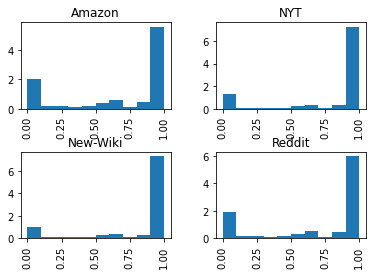

In [8]:
df_pred['f1'].hist(by=df_pred['test_set'],density=True)

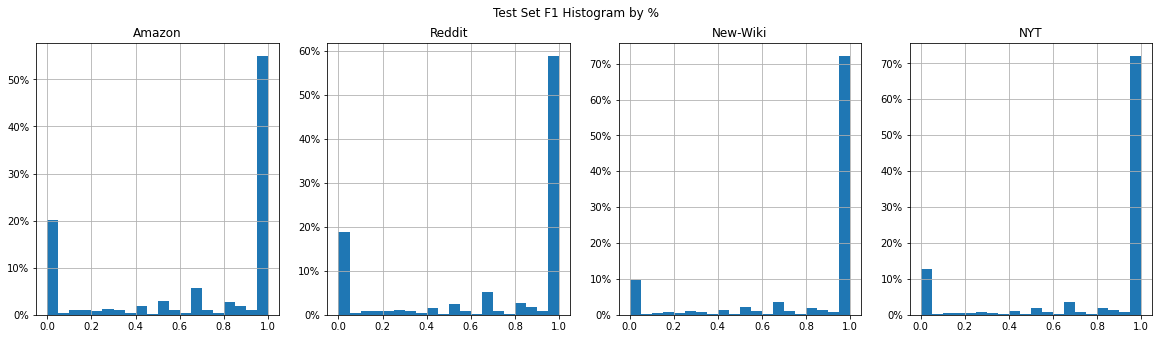

In [9]:
fig, axes = plt.subplots(1,4, figsize= (20,5))
fig.suptitle('Test Set F1 Histogram by %')
for i, test_set in enumerate(df_pred['test_set'].unique()):
    data = df_pred[df_pred['test_set'] == test_set]['f1']
    data.hist(ax=axes.flat[i], 
            bins=20, 
            weights=np.ones(len(data)) / len(data) 
           )
    axes.flat[i].set_title(test_set)
for ax in axes:
    ax.yaxis.set_major_formatter(PercentFormatter(1))

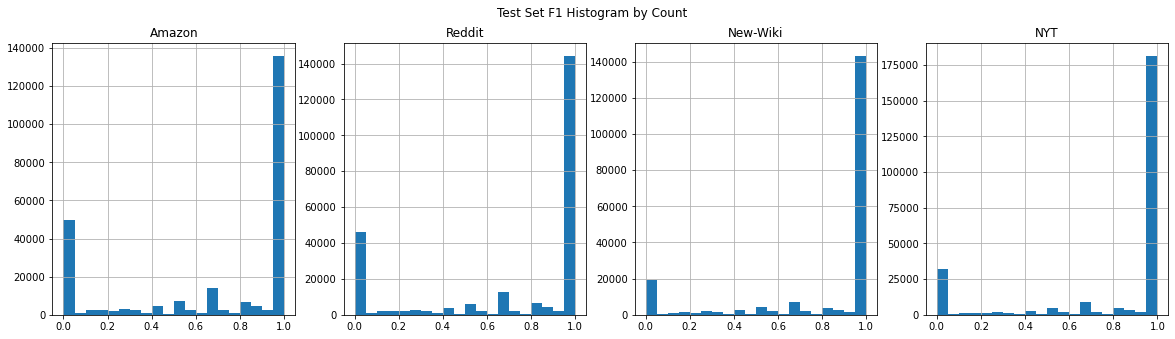

In [10]:
fig, axes = plt.subplots(1,4, figsize= (20,5))
fig.suptitle('Test Set F1 Histogram by Count')
for i, test_set in enumerate(df_pred['test_set'].unique()):
    data = df_pred[df_pred['test_set'] == test_set]['f1']
    data.hist(ax=axes.flat[i], 
            bins=20
           )
    axes.flat[i].set_title(test_set)

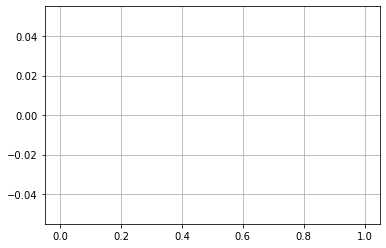

In [11]:
df_pred[df_pred['test_set'] == 'dev-v1.1']['f1'].hist(bins=1)

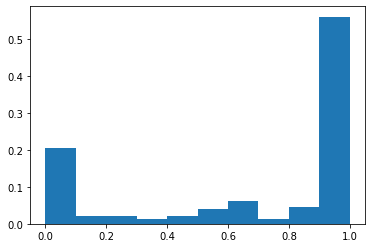

In [12]:
fig, axes = plt.subplots(1,1)
axes.hist(df_pred[df_pred['test_set'] == 'Amazon']['f1'], 
          weights=np.ones(len(df_pred[df_pred['test_set'] == 'Amazon']['f1'])) / len(df_pred[df_pred['test_set'] == 'Amazon']['f1']) )
plt.show()

In [13]:
df_answers['is_numeric'] = df_answers.apply(lambda row: row['answer_text'].isnumeric(), axis=1)
df_answers[df_answers['is_numeric']]
df_answers.to_csv('answers.csv', index=False)

In [85]:
nlp = stanfordnlp.Pipeline(processors='tokenize', use_gpu=True)

Use device: gpu
---
Loading: tokenize
With settings: 
{'model_path': 'C:\\Users\\Justin\\stanfordnlp_resources\\en_ewt_models\\en_ewt_tokenizer.pt', 'lang': 'en', 'shorthand': 'en_ewt', 'mode': 'predict'}
Done loading processors!
---


In [15]:
def get_all_stanford_metrics(txt):
    subtree_value = ''
    ner = '_NO_NER'
    sentence_count = 0
    word_count = 0 
    character_count = 0
    
    try:
        with CoreNLPClient(endpoint='http://localhost:9001', start_server=False, timeout=30000) as client:

            ann = client.annotate(txt)
            
            sentence_count = len(ann.sentence)
            words = [x.word for s in ann.sentence for x in s.token if x.word not in string.punctuation]
            word_count = len(words)
            character_count = sum([len(x) for x in words])
            
            sentence = ann.sentence[0]
            if sentence.mentions:
                ner = sentence.mentions[0].entityType
            
            constituency_parse = sentence.parseTree
            subtree_value = constituency_parse.child[0].value
        
        return subtree_value, ner, sentence_count, word_count, character_count
        
    except Exception as e:
        return e.args[0],e.args[0], e.args[0], e.args[0],e.args[0]
    
# def get_stanford_counts(txt):
#     sentence_count = 0
#     word_count = 0 
#     character_count = 0
    
#     try:
#         with CoreNLPClient(endpoint='http://localhost:9001', annotators='tokenize,ssplit', start_server=False, timeout=30000) as client:
            
#             ann = client.annotate(txt)
            
#             sentence_count = len(ann.sentence)
#             words = [x.word for s in ann.sentence for x in s.token if x.word not in string.punctuation]
#             word_count = len(words)
#             character_count = sum([len(x) for x in words])
        
#         return sentence_count, word_count, character_count
        
#     except Exception as e:
#         return e.args[0], e.args[0], e.args[0]
    
    
def get_stanford_counts(txt):
    sentence_count = 0
    word_count = 0 
    character_count = 0
    
    try:
        doc = nlp(txt)
        sentence_count = len(doc.sentences)
        words = [w.text for s in doc.sentences for w in s.words if w.text not in string.punctuation]
        word_count = len(words)
        character_count = sum([len(x) for x in words])
        
        return sentence_count, word_count, character_count, words
        
    except Exception as e:
        return e.args[0], e.args[0], e.args[0]
    
# def get_ner(txt):
#     try:
#         with CoreNLPClient(endpoint='http://localhost:9001', start_server=False, timeout=30000) as client:
#             ann = client.annotate(txt)
#             sentence = ann.sentence[0]
#             if sentence.mentions:
#                 return sentence.mentions[0].entityType

#     except Exception as e:
#         return e.args[0]

In [16]:
# Test Server
try:
    txt = 'This is a test sentence. So is this.'
    with CoreNLPClient(endpoint='http://localhost:9001', start_server=False, timeout=30000) as client:
        ann = client.annotate(txt)
        print('Server running. Found {} sentences'.format(len(ann.sentence)))
except Exception as e:
    print(e)

Server running. Found 2 sentences


In [17]:
# Write new results, if necessary
df_distinct_answers = pd.DataFrame({'answer_text': df_answers['answer_text'].unique()})
df_distinct_answers[['first_parse', 'first_ner', 'sentence_count', 'word_count', 'word_character_count', ]] = df_distinct_answers.apply(lambda row: get_all_stanford_metrics(row['answer_text']), axis=1, result_type='expand')


In [18]:
df_distinct_answers.fillna(value = {'first_ner':'_NO_NER'}).groupby(['first_ner']).count()
df_distinct_answers.to_csv('distinct_answers.csv', index=False)

In [19]:
df_distinct_context = pd.DataFrame({'context': df_answers['context'].unique()})

In [20]:
df_distinct_context[['sentence_count', 'word_count', 'word_character_count', 'words']] = df_distinct_context.apply(lambda row: get_stanford_counts(row['context']), axis=1, result_type='expand')

In [21]:
syll_df = dd.from_pandas(df_distinct_context, npartitions = 2*multiprocessing.cpu_count()) \
            .map_partitions(lambda df: df.apply(lambda row: [max(1, len(Hyphenator('en_US').syllables(x))) if len(str(x)) < 100 else -1 for x in row['words'] ], axis = 1)) \
            .compute(scheduler='processes')

In [22]:
df_distinct_context['syllables_per_word'] = syll_df

In [23]:
df_distinct_context['polysyllable_count'] = df_distinct_context.apply(lambda row: len([x for x in row['syllables_per_word'] if x > 1]), axis = 1)
df_distinct_context['avg_word_length'] = df_distinct_context.apply(lambda row: sum([len(x) for x in row['words']])/row['word_count'], axis = 1)

In [24]:
df_distinct_context['avg_sentence_length_in_words'] = df_distinct_context['word_count']/df_distinct_context['sentence_count']
df_distinct_context['context_character_count'] = df_distinct_context.apply(lambda row: len(row['context']), axis=1)
df_distinct_context['avg_sentence_length_in_characters'] = df_distinct_context['context_character_count']/df_distinct_context['sentence_count']
df_distinct_context['syllables_per_word'] = df_distinct_context.apply(lambda row: sum([x for x in row['syllables_per_word'] if x > 0])/ len([x for x in row['syllables_per_word'] if x > 0]) , axis=1)
df_distinct_context['flesch-kincaid_grade_level'] = df_distinct_context.apply(lambda row: (0.39 * row['avg_sentence_length_in_words']) + (11.8 * row['syllables_per_word']) - 15.59, axis=1)


In [25]:
df_distinct_context['coleman-liau'] = df_distinct_context.apply(lambda row: (0.0588 * (row['avg_word_length']) * 100) - (0.296 * (100/row['avg_sentence_length_in_words'])) - 15.8, axis=1)
df_distinct_context['gunning-fog'] = df_distinct_context.apply(lambda row: 0.4 * ((row['word_count'] / row['sentence_count']) + ((row['polysyllable_count'] / row['word_count']) * 100)), axis=1)
df_distinct_context['automated-readability'] = df_distinct_context.apply(lambda row: 4.71 * (row['context_character_count'] / row['word_count']) + 0.5 * (row['word_count'] / row['sentence_count']) - 21.43, axis=1)


In [83]:
df_distinct_context.sort_values('flesch-kincaid_grade_level', ascending=False).iloc[2]['context']

'...first off dont even attempt to fry eggsin this skillet for at least 2 weeks of using....when i recived mine i washed well in hot water, even tho it seasoned your gonna wanna do it theright way...after washing put on top stove to dry,then cooked bacon in it, you are gonna wanna useanimal fat as much as possiable.....it did stick but thats toobe expected with first time use, then i towel dryedthe extra grease and added lard....put in oven at 500degrees, expect some smoking, just have fans ready, for1 hr...turn oven off, i did this like 3-4 times...thencooked fried potatoes with onions ,worked great, friedan egg and it slid off pan...great pan, just got dutch oven too...'

In [90]:
df_distinct_context.iloc[1519]

context                              ...first off dont even attempt to fry eggsin t...
sentence_count                                                                       1
word_count                                                                         142
word_character_count                                                               551
words                                ['...', 'first', 'off', 'do', 'nt', 'even', 'a...
syllables_per_word                                                             1.14789
polysyllable_count                                                                  18
avg_word_length                                                                3.88028
avg_sentence_length_in_words                                                       142
context_character_count                                                            679
avg_sentence_length_in_characters                                                  679
flesch-kincaid_grade_level                 

In [89]:
df_distinct_context.sort_values(
    'flesch-kincaid_grade_level', 
    ascending=False).iloc[2:3][[
                                'sentence_count', 
                                'word_count', 
                                'flesch-kincaid_grade_level', 
                                'coleman-liau', 
                                'gunning-fog', 
                                'automated-readability']]

,sentence_count,word_count,flesch-kincaid_grade_level,coleman-liau,gunning-fog,automated-readability
1519,1,142,53.33507,6.807606,61.870423,72.091761


In [86]:
len(nlp(df_distinct_context.sort_values('flesch-kincaid_grade_level', ascending=False).iloc[2]['context']).sentences)

1

In [29]:
df_distinct_context.sort_values('flesch-kincaid_grade_level', ascending=False)

,context,sentence_count,word_count,word_character_count,words,syllables_per_word,polysyllable_count,avg_word_length,avg_sentence_length_in_words,context_character_count,avg_sentence_length_in_characters,flesch-kincaid_grade_level,coleman-liau,gunning-fog,automated-readability
573,very well built although it might be difficult...,1,162,690,"[very, well, built, although, it, might, be, d...",1.209877,27,4.259259,162.000000,852,852.000000,61.866543,9.061728,71.466667,84.341111
2595,At present there are a number of medical schoo...,1,139,787,"[At, present, there, are, a, number, of, medic...",1.489209,52,5.661871,139.000000,945,945.000000,56.192662,17.278849,70.564029,80.091223
1519,...first off dont even attempt to fry eggsin t...,1,142,551,"[..., first, off, do, nt, even, attempt, to, f...",1.147887,18,3.880282,142.000000,679,679.000000,53.335070,6.807606,61.870423,72.091761
4129,Her decision to quit the tights-and-cape exist...,1,126,586,"[Her, decision, to, quit, the, tights, and, ca...",1.388889,34,4.650794,126.000000,735,735.000000,49.938889,11.311746,61.193651,69.045000
2400,Firms may prefer decentralization because it e...,1,101,545,"[Firms, may, prefer, decentralization, because...",1.633663,41,5.396040,101.000000,652,652.000000,43.077228,15.635644,56.637624,59.475149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6059,I need some new music :). I've tripped a coupl...,6,34,138,"[I, need, some, new, music, :), I, 've, trippe...",1.176471,5,4.058824,5.666667,177,29.500000,0.502353,2.842353,8.149020,5.923039
7569,SP 4 stops running Far Cry 3? I've tried playi...,6,42,142,"[SP, 4, stops, running, Far, Cry, 3, I, 've, t...",1.119048,5,3.380952,7.000000,190,31.666667,0.344762,-0.148571,7.561905,3.377143
7026,"Three Friends Boasting. John, Peter and James ...",18,124,510,"[Three, Friends, Boasting, John, Peter, and, J...",1.120968,14,4.112903,6.888889,683,37.944444,0.324086,4.087097,7.271685,7.957428
1511,"Yes, it's ok. That's about it. had bought a Ki...",8,50,211,"[Yes, it, 's, ok, That, 's, about, it, had, bo...",1.140000,6,4.220000,6.250000,270,33.750000,0.299500,4.277600,7.300000,7.129000


In [30]:
df_distinct_context.sort_values('flesch-kincaid_grade_level', ascending=False).iloc[1]

context                              At present there are a number of medical schoo...
sentence_count                                                                       1
word_count                                                                         139
word_character_count                                                               787
words                                [At, present, there, are, a, number, of, medic...
syllables_per_word                                                             1.48921
polysyllable_count                                                                  52
avg_word_length                                                                5.66187
avg_sentence_length_in_words                                                       139
context_character_count                                                            945
avg_sentence_length_in_characters                                                  945
flesch-kincaid_grade_level                 

In [31]:
x = 'University of the Philippines College of Medicine'.split()
for w in x:
    print(w, Hyphenator('en_US').syllables(w))

University ['Univer', 'sity']
of []
the []
Philippines ['Philip', 'pines']
College ['Col', 'lege']
of []
Medicine ['Medicine']


In [79]:
#df_distinct_context.to_csv('distinct_context.csv', index=False)
df_distinct_context = pd.read_csv('distinct_context.csv')

In [33]:
# Read from saved file
#df_distinct_answers = pd.read_csv('distinct_answers.csv')

In [34]:
df_merged_answers = df_answers.merge(df_distinct_answers, on=['answer_text'])   

In [35]:
df_merged_answers['is_numeric'] = df_merged_answers.apply(lambda row: row['answer_text'].isnumeric(), axis=1)
df_merged_answers.to_csv('merged_answers.csv', index=False)

In [36]:
df_merged_answers[df_merged_answers['question_id'] == '5dd469facc027a086d65bf1a']

,test_set,question_id,title,context,question_text,answer_text,answer_start,is_numeric,first_parse,first_ner,sentence_count,word_count,word_character_count
4541,amazon_reviews_v1,5dd469facc027a086d65bf1a,Amazon_Reviews_655,"I got two of these: one is 6,00 BTU, another i...",do the models have the same design?,same design flows,78,False,S,_NO_NER,1,3,15
4542,amazon_reviews_v1,5dd469facc027a086d65bf1a,Amazon_Reviews_655,"I got two of these: one is 6,00 BTU, another i...",do the models have the same design?,.Both models have the same design,56,False,.,_NO_NER,2,6,27
4543,amazon_reviews_v1,5dd469facc027a086d65bf1a,Amazon_Reviews_655,"I got two of these: one is 6,00 BTU, another i...",do the models have the same design?,Both models have the same design flows,57,False,S,_NO_NER,1,7,32


In [37]:
df_merged_answers[df_merged_answers['is_numeric']].groupby('first_parse').count()

,test_set,question_id,title,context,question_text,answer_text,answer_start,is_numeric,first_ner,sentence_count,word_count,word_character_count
first_parse,,,,,,,,,,,,
FRAG,4606,4606,4606,4606,4606,4606,4606,4606,4606,4606,4606,4606
LST,152,152,152,152,152,152,152,152,152,152,152,152
META,4,4,4,4,4,4,4,4,4,4,4,4
NP,33,33,33,33,33,33,33,33,33,33,33,33


In [45]:
df_merged_answers_and_context = df_merged_answers.merge(df_distinct_context, on=['context'])   

In [3]:
#df_merged_answers_and_context.to_csv('merged_answers_and_context.csv', index = False)

df_merged_answers_and_context = pd.read_csv('merged_answers_and_context.csv')

In [4]:
df_merged_answers_and_context.columns

Index(['test_set', 'question_id', 'title', 'context', 'question_text',
       'answer_text', 'answer_start', 'is_numeric', 'first_parse', 'first_ner',
       'sentence_count_x', 'word_count_x', 'word_character_count_x',
       'sentence_count_y', 'word_count_y', 'word_character_count_y', 'words',
       'syllables_per_word', 'polysyllable_count', 'avg_word_length',
       'avg_sentence_length_in_words', 'context_character_count',
       'avg_sentence_length_in_characters', 'flesch-kincaid_grade_level',
       'coleman-liau', 'gunning-fog', 'automated-readability'],
      dtype='object')

In [8]:
df_pred_answers_context = df_pred.merge(df_merged_answers_and_context, left_on=['qid'], right_on=['question_id'])

In [9]:
df_pred_answers_context.to_csv('pred_answers_context.csv', index=False)

In [23]:
df_pred_answers_context[(df_pred_answers_context['test_set_x'] == 'Amazon') & (df_pred_answers_context['model_name'] == 'xlnet-123(singlemodel)')][['f1','syllables_per_word']].corr()

,f1,syllables_per_word
f1,1.000000,0.010001
syllables_per_word,0.010001,1.000000


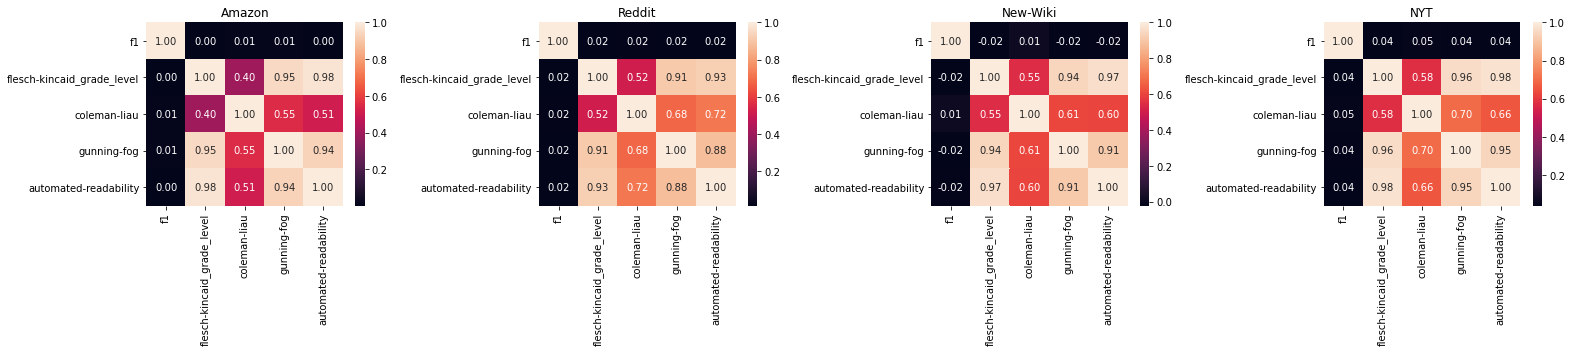

In [76]:
fig, axes = plt.subplots(1,4, figsize= (22,5))

metric_list = ['f1','syllables_per_word', 'polysyllable_count','avg_word_length','avg_sentence_length_in_words','context_character_count',
                                          'avg_sentence_length_in_characters','flesch-kincaid_grade_level','coleman-liau','gunning-fog','automated-readability']
metric_list = ['f1', 'flesch-kincaid_grade_level','coleman-liau','gunning-fog','automated-readability']
for i, model in enumerate(SET_NAMES):
    corrMatrix = df_pred_answers_context[(df_pred_answers_context['test_set_x'] == model)][metric_list].corr()
#     print(model)
#    print(corrMatrix[0])
#     print('\n')
    
    p = sns.heatmap(corrMatrix, annot=True, ax = axes.flat[i], fmt=".2f")
    axes.flat[i].set_title(model)

    #p.set_xticklabels(p.get_xticklabels(), rotation = 0)
    
fig.tight_layout()
plt.savefig('test.jpg')    

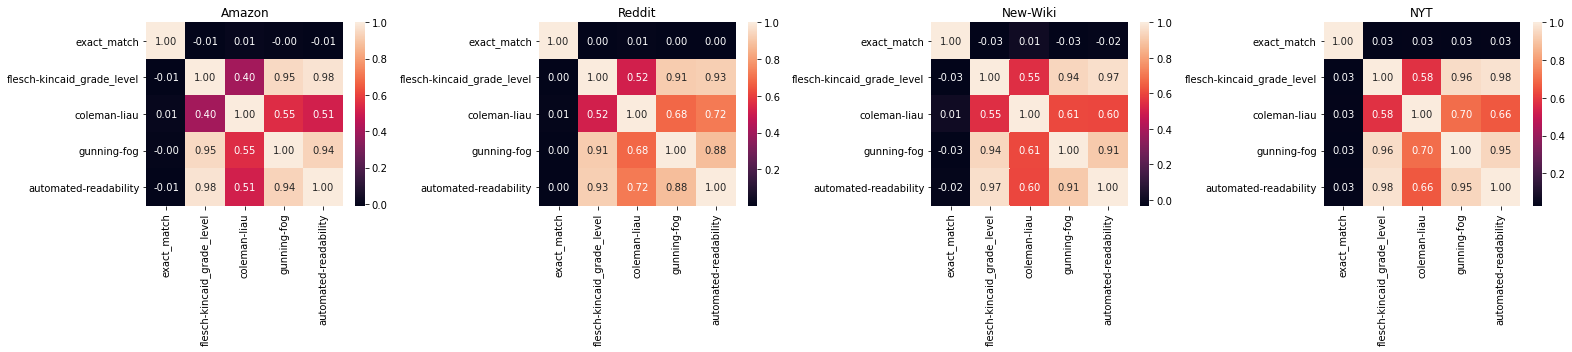

In [75]:
fig, axes = plt.subplots(1,4, figsize= (22,5))

metric_list = ['exact_match','syllables_per_word', 'polysyllable_count','avg_word_length','avg_sentence_length_in_words','context_character_count',
                                          'avg_sentence_length_in_characters','flesch-kincaid_grade_level','coleman-liau','gunning-fog','automated-readability']
metric_list = ['exact_match', 'flesch-kincaid_grade_level','coleman-liau','gunning-fog','automated-readability']
for i, model in enumerate(SET_NAMES):
    corrMatrix = df_pred_answers_context[(df_pred_answers_context['test_set_x'] == model)][metric_list].corr()
#     print(model)
#    print(corrMatrix[0])
#     print('\n')
    
    p = sns.heatmap(corrMatrix, annot=True, ax = axes.flat[i], fmt=".2f")
    axes.flat[i].set_title(model)

    #p.set_xticklabels(p.get_xticklabels(), rotation = 0)
    
fig.tight_layout()
plt.savefig('test.jpg') 

In [73]:
df_pred_answers_context['exact_match'] = df_pred_answers_context['exact_match'].map({'True':True, 'False':False})

In [108]:
pd.set_option('display.max_rows', 20)
df_pred_answers_context[df_pred_answers_context['context'] == df_distinct_context.sort_values('flesch-kincaid_grade_level', ascending=False).iloc[2]['context']][['question_text', 'answer_text', 'predicted_answer', 'f1', 'exact_match']].drop_duplicates()

,question_text,answer_text,predicted_answer,f1,exact_match
505125,What should you wait 2 weeks to do?,fry eggs,fry eggs,1.000000,True
505126,What should you wait 2 weeks to do?,fry eggsin,fry eggs,1.000000,True
505127,What should you wait 2 weeks to do?,fry eggsin this skillet,fry eggs,1.000000,True
505128,What should you wait 2 weeks to do?,fry eggs,dont even attempt to fry eggsin this skillet,0.666667,False
505129,What should you wait 2 weeks to do?,fry eggsin,dont even attempt to fry eggsin this skillet,0.666667,False
...,...,...,...,...,...
505467,What did they purchase after getting the skillet?,dutch oven,bacon,0.000000,False
505476,What did they purchase after getting the skillet?,dutch oven,2 weeks,0.000000,False
505482,What did they purchase after getting the skillet?,dutch oven,washing,0.000000,False
505488,What did they purchase after getting the skillet?,dutch oven,towel dryedthe extra grease and added lard,0.000000,False


In [93]:
df_pred_answers_context.columns

Index(['display_name', 'model_name', 'description', 'uuid', 'testbed',
       'test_set_x', 'qid', 'predicted_answer', 'exact_match', 'f1',
       'test_set_y', 'question_id', 'title', 'context', 'question_text',
       'answer_text', 'answer_start', 'is_numeric', 'first_parse', 'first_ner',
       'sentence_count_x', 'word_count_x', 'word_character_count_x',
       'sentence_count_y', 'word_count_y', 'word_character_count_y', 'words',
       'syllables_per_word', 'polysyllable_count', 'avg_word_length',
       'avg_sentence_length_in_words', 'context_character_count',
       'avg_sentence_length_in_characters', 'flesch-kincaid_grade_level',
       'coleman-liau', 'gunning-fog', 'automated-readability'],
      dtype='object')

In [107]:
Hyphenator('en_US').syllables('extraordinary')

['ex', 'tra', 'or', 'di', 'nary']